In [145]:
lr = 1e-5
wd = 1e-5
batch_size = 2
image_size = 256


In [7]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

TRAIN_CORONAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_coronal_images")
TRAIN_CORONAL_LABEL_DIR = os.path.join(DATA_DIR, "train_coronal_labels")
TRAIN_SAGITTAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_sagittal_images_jpeg95")
TRAIN_SAGITTAL_LABEL_DIR = os.path.join(DATA_DIR, "train_sagittal_labels_jpeg95")

In [11]:
bbox_df = pd.read_csv('train_bbox_sagittal_classification.csv').set_index("UID")
bbox_df.head()

,StudyInstanceUID,start_slice_number,bottom,right,top,left,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,...,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,126,125,132,226,...,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,127,126,133,229,...,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,129,129,134,234,...,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,130,129,135,234,...,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,131,130,136,237,...,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


0.5


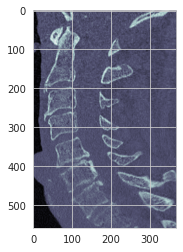

In [17]:
class SagittalDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, image_size=256, transform=None):
        super().__init__()

        self.df = df
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        s = self.df.iloc[idx]
        UID = s.name
        img = Image.open(os.path.join(self.image_dir, UID, f"{int(s.sagittal_index)}.jpeg"))
        img = TF.crop(img, s.top, s.left, s.bottom - s.top, s.right - s.left)

        mask = Image.open(os.path.join(self.mask_dir, UID, f"{int(s.sagittal_index)}.png"))
        mask = np.asarray(mask)
        # print(mask.shape)
        # print(self.image_size)
        row = np.clip(s.sagittal_label_y, a_min=0, a_max=(self.image_size-1))
        column = np.clip(s.sagittal_label_x, a_min=0, a_max=(self.image_size-1))
        # print(row, column)
        label = mask[row, column] / 32.
        if self.transform:
            img, mask, label = self.transform(img, mask, label)

        return img, mask, label

dataset = SagittalDataset(bbox_df, TRAIN_SAGITTAL_IMAGES_DIR, TRAIN_SAGITTAL_LABEL_DIR)
img, mask, label = dataset[1]

print(label)
plt.imshow(img, cmap='bone')

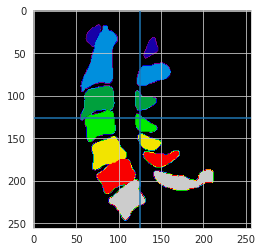

In [18]:
plt.imshow(mask, cmap="nipy_spectral")
plt.axhline(126)
plt.axvline(125)

In [19]:
label

0.5

### Transform

In [63]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        # self.mask_transform = T.Normalize(0, 32)

        self.label_transform = T.ToTensor()

    def forward(self, x, mask, label):
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        # print(mask)
        mask = torch.tensor(mask, dtype=torch.float) / 32.
        mask = mask
        # mask = self.mask_transform(mask)
        label = label / 0.125 - 1
        label = torch.tensor(label).long()
        return x, mask, label
transform = DataTransform(image_size)

In [64]:
dataset = SagittalDataset(bbox_df, TRAIN_SAGITTAL_IMAGES_DIR, TRAIN_SAGITTAL_LABEL_DIR, transform=transform)
img, mask, label = dataset[1]
print(label)
mask.max()

tensor(3)


tensor(0.8750)

In [98]:
def get_backbone():
    backbone = models.resnet50(pretrained=True)
    conv1_weight = backbone.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    backbone.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return nn.ModuleList([
        nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool),
        nn.Sequential(
            backbone.layer1,
            backbone.layer2,
        ),
        backbone.layer3,
        backbone.layer4
    ]), [1, 64, 512, 1024, 2048]

backbone, channels = get_backbone()
print(backbone)

ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [23]:
def print_list_shape(list):
    for i, l in enumerate(list):
        print(f"{i} {l.shape}")

In [125]:
class ClassificationModel(nn.Module):
    def __init__(self, backbone, channels, deep=4):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels

        self.dw = nn.Parameter(torch.tensor(10.0, dtype=torch.float), requires_grad=True)
        self.register_buffer('mf', ((torch.arange(7) + 1) * 0.125).reshape(7, 1, 1))
        self.init_layers()

    def init_layers(self):
        self.parallel_modules_1 = self.make_parallel_modules()
        self.parallel_modules_2 = self.make_parallel_modules()
        self.downsampling_modules = self.make_downsampling_modules()
        self.mask_modules = self.make_mask_modules()
        self.classification_modules = self.make_classification_modules()

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for channel in self.channels:
            module = nn.Conv2d(channel, channel, kernel_size=3, padding='same')
            parallel_modules.append(module)

        return parallel_modules

    def make_mask_modules(self):
        mask_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.Conv2d(self.channels[i], self.channels[i+1], kernel_size=3, stride=2, padding=1),
                nn.Sigmoid()
            )
            mask_modules.append(module)

        return mask_modules

    def make_downsampling_modules(self):
        downsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i+1], kernel_size=3, stride=2, padding=1),
            )
            downsampling_modules.append(module)

        return downsampling_modules

    def make_classification_modules(self):
        return nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(self.channels[-1], self.channels[-1], kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.channels[-1] * 16 * 16, 1)
        )

    def forward_recursive(self, x, modules):
        result = []
        out = x
        for module in modules:
            out = module(out)
            result.append(out)

        return result

    def forward_parallel(self, inputs, modules):
        result = []
        for input, module in zip(inputs, modules):
            out = module(input)
            result.append(out)

        return result

    def apply_mask(self, inputs, masks):
        result = []

        for input, mask in zip(inputs, masks):
            out = input * mask
            result.append(out)

        return result

    def repeat_mask(self, mask):
        N, H, W = mask.shape
        mask[mask == 0] = -torch.inf

        mask = (mask.unsqueeze(1) - self.mf) ** 2
        mask = torch.exp(-self.dw * mask)  # N, 7, H, W
        mask = mask.reshape(-1, 1, H, W)
        return mask

    def forward_downsampling(self, features, modules):
        out = features[0]
        for i, module in enumerate(modules):
            out = module(out) + features[i + 1]

        return out

    def forward(self, x, mask):
        backbone_features = self.forward_recursive(x, self.backbone)
        check_list_nan(backbone_features, "backbone_features")

        mask = self.repeat_mask(mask)   # 14, 1, 256, 256
        mask_features = self.forward_recursive(mask, self.mask_modules)

        check_list_nan(mask_features)

        parallel_features_1 = self.forward_parallel([x] + backbone_features, self.parallel_modules_1)
        # 여기서 뻥튀기를 시킨다.
        parallel_features_1 = [feature.repeat_interleave(7, dim=0) for feature in parallel_features_1]

        check_list_nan(parallel_features_1)

        masked_features = self.apply_mask(parallel_features_1, [mask] + mask_features)

        check_list_nan(masked_features)
        out = self.forward_parallel(masked_features, self.parallel_modules_2)

        check_list_nan(out)
        out = self.forward_downsampling(out, self.downsampling_modules)
        out = self.classification_modules(out)

        return out


model = ClassificationModel(backbone, channels).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

# input = torch.randn(2, 1, 256, 256)
# mask = torch.randn(2, 256, 256)
# logits = model(input, mask)
# logits.shape

208732502

### Dataloader

In [65]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=min(16, batch_size))

### Optimizer

In [123]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)


### Loss function

In [73]:
def loss_fn(logits, y, pos_weight=torch.tensor(1)):
    labels = F.one_hot(y, num_classes=7).reshape(-1, 1).float()

    loss = F.binary_cross_entropy_with_logits(logits, labels, pos_weight=pos_weight)
    return loss


In [108]:
x, mask, y = next(iter(dataloader))
print(x.shape)
print(mask.shape)
print(y.shape)

torch.Size([2, 1, 256, 256])
torch.Size([2, 256, 256])
torch.Size([2])


In [80]:
F.one_hot(y, num_classes=7)

tensor([[0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]], device='cuda:0')

In [86]:
torch.isnan(x).any()

tensor(False, device='cuda:0')

In [106]:
def check_list_nan(list, name=None):
    print("check_list_nan {}".format(name))
    for i, item in enumerate(list):
        print(f"{i} {torch.isnan(item).any()}")

In [93]:

print(x.min())
print(x.max())

tensor(-1., device='cuda:0')
tensor(1., device='cuda:0')


In [96]:
x.isnan().any()

tensor(False, device='cuda:0')

In [105]:
backbone[0].to(device)(x)

tensor([[[[2.4243, 2.4243, 2.1280,  ..., 2.1280, 2.1280, 1.8157],
          [1.5168, 1.5168, 1.4492,  ..., 1.4492, 1.4949, 1.4949],
          [0.3992, 0.3992, 0.3200,  ..., 0.3200, 0.4693, 0.4693],
          ...,
          [0.3992, 0.3992, 0.3200,  ..., 0.3200, 0.4693, 0.4693],
          [1.7358, 1.7358, 1.6732,  ..., 1.6732, 1.7765, 1.7765],
          [1.8658, 2.2373, 2.2373,  ..., 2.2373, 2.5965, 2.5965]],

         [[0.8236, 0.8236, 0.5830,  ..., 0.5830, 0.6348, 0.6348],
          [0.7861, 0.7861, 0.5636,  ..., 0.5636, 0.6261, 0.6261],
          [0.5757, 0.5757, 0.1948,  ..., 0.1948, 0.3159, 0.3262],
          ...,
          [0.5757, 0.5757, 0.1948,  ..., 0.1948, 0.3159, 0.3262],
          [0.6873, 0.6873, 0.3701,  ..., 0.3701, 0.4513, 0.4513],
          [0.6873, 0.6873, 0.3701,  ..., 0.3701, 0.4513, 0.4581]],

         [[0.4886, 0.5512, 0.5372,  ..., 0.5372, 0.5372, 0.4779],
          [0.4344, 0.5040, 0.4768,  ..., 0.4768, 0.4768, 0.4280],
          [0.4138, 0.4877, 0.4497,  ..., 0

In [146]:
backbone, channels = get_backbone()
model = ClassificationModel(backbone, channels).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# total_params


In [141]:
backbone[0][0].weight.grad

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        ...,


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, 

In [148]:
model.train()

x, mask, y = next(iter(dataloader))
x, mask, y = x.to(device), mask.to(device), y.to(device)
logits = model(x, mask)
print(logits)
loss = loss_fn(logits, y)
print(loss.item())
optimizer.zero_grad()
loss.backward()
# backbone[0][0].weight.grad
nn.utils.clip_grad_norm_(model.parameters(), 1.)
optimizer.step()

check_list_nan backbone_features
0 True
1 True
2 True
3 True
check_list_nan None
0 True
1 True
2 True
3 True
check_list_nan None
0 True
1 True
2 True
3 True
4 True
check_list_nan None
0 True
1 True
2 True
3 True
4 True
check_list_nan None
0 True
1 True
2 True
3 True
4 True
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<AddmmBackward0>)
nan


In [150]:
backbone[0][0].weight.grad.max()

tensor(nan, device='cuda:0')

In [39]:
def denormalize_img(x):
    img = x.detach().cpu().numpy()
    img = (img * 0.5) + 0.5
    img = img.transpose(0, 2, 3, 1)
    return img

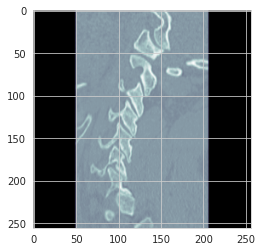

In [41]:
img = denormalize_img(x)
plt.imshow(img[0], cmap='bone')

In [46]:
y

tensor([3., 3.], device='cuda:0')